In [65]:
import casadi as ca
import matplotlib.pyplot as plt
import numpy as np


def R1(theta):
    return ca.vertcat(
        ca.horzcat(1, 0, 0),
        ca.horzcat(0, ca.cos(theta), ca.sin(theta)),
        ca.horzcat(0, -ca.sin(theta), ca.cos(theta)),
    )


def R2(theta):
    return ca.vertcat(
        ca.horzcat(ca.cos(theta), 0, -ca.sin(theta)),
        ca.horzcat(0, 1, 0),
        ca.horzcat(ca.sin(theta), 0, ca.cos(theta)),
    )


def R3(theta):
    return ca.vertcat(
        ca.horzcat(ca.cos(theta), ca.sin(theta), 0),
        ca.horzcat(-ca.sin(theta), ca.cos(theta), 0),
        ca.horzcat(0, 0, 1),
    );

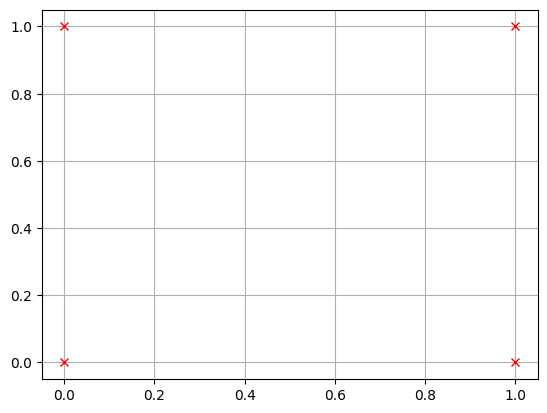

In [73]:
# input
thr = ca.SX.sym("thr")
el = ca.SX.sym("el")
rdr = ca.SX.sym("rdr")
u_vect = ca.vertcat(thr, el, rdr)

# state
U = ca.SX.sym("U")
V = ca.SX.sym("V")
W = ca.SX.sym("W")
phi = ca.SX.sym("phi")
theta = ca.SX.sym("theta")
psi = ca.SX.sym("psi")
P = ca.SX.sym("P")
Q = ca.SX.sym("Q")
R = ca.SX.sym("R")
p_N = ca.SX.sym("p_N")
p_E = ca.SX.sym("p_E")
h = ca.SX.sym("h")
x_vect = ca.vertcat(U, V, W, phi, theta, psi, P, Q, R, p_N, p_E, h)

# parameters
g = ca.SX.sym("g")
J_x = ca.SX.sym("J_x")
J_y = ca.SX.sym("J_y")
J_z = ca.SX.sym("J_z")
J_xz = ca.SX.sym("J_xz")
m = ca.SX.sym("m")
rho = ca.SX.sym("rho")
CL_0 = ca.SX.sym("CL_0")
CL_a = ca.SX.sym("CL_a")
CD_0 = ca.SX.sym("CD_0")
k_CDCL = ca.SX.sym("k_CDCL")
S = ca.SX.sym("S")
p_vect = ca.vertcat(g, m, J_x, J_y, J_z, J_xz, CL_0, CL_a, CD_0, k_CDCL, S)

p_dict = {
    g: 9.8,
    m: 0.1,
    J_x: 0.01,
    J_y: 0.01,
    J_z: 0.01,
    J_xz: 0,
    CL_0: 0,
    CL_a: 0,
    CD_0: 0,
    k_CDCL: 0.01,
    S: 0.01,
}

# forces
V_T = ca.norm_2(ca.vertcat(U, V, W))
alpha = ca.if_else(ca.fabs(U) > 1e-2, ca.atan(W / U), 0)
beta = ca.if_else(ca.fabs(V_T) > 1e-2, ca.asin(V / V_T), 0)

Fx = 1
Fy = 1
Fz = 1

# moments
Mx = 1
My = 1
Mz = 1

sin_theta = ca.sin(theta)
cos_theta = ca.cos(theta)
tan_theta = ca.tan(theta)

sin_phi = ca.sin(phi)
cos_phi = ca.cos(phi)

# force equations
U_dot = R * V - Q * W - g * sin_theta + Fx / m
V_dot = -R * U + P * W + g * sin_phi * cos_theta + Fy / m
W_dot = Q * U - P * V + g * cos_phi * cos_theta + Fz / m

# kinematic equations
phi_dot = P + tan_theta * (Q * sin_phi + R * cos_phi)
theta_dot = Q * cos_phi - R * sin_phi
psi_dot = (Q * sin_phi + R * cos_phi) / cos_theta

# moment equations
Gamma = J_x * J_z - J_xz**2
c1 = ((J_y - J_z) * J_z - J_xz**2) / Gamma
c2 = (J_x - J_y + J_z) * J_xz / Gamma
c3 = J_z / Gamma
c4 = J_xz / Gamma
c5 = (J_z - J_x) / J_y
c6 = J_xz / J_y
c7 = 1 / J_y
c8 = (J_x * (J_x - J_y) + J_xz**2) / Gamma
c9 = J_x / Gamma
P_dot = (c1 * R + c2 * P) * Q + c3 * Mx + c4 * Mz
Q_dot = c5 * P * R - c6 * (P**2 - R**2) + c7 * My
R_dot = (c8 * P - c2 * R) * Q + c4 * Mx + c9 * Mz

# navigation equations
R_nb = R1(phi) @ R2(theta) @ R3(psi)
V_T_n = R_nb @ ca.vertcat(U, V, W)
p_n_dot = V_T_n[0]
p_e_dot = V_T_n[1]
h_dot = V_T_n[2]

x_dot_vect = ca.vertcat(
    U_dot,
    V_dot,
    W_dot,
    phi_dot,
    theta_dot,
    psi_dot,
    P_dot,
    Q_dot,
    R_dot,
    p_n_dot,
    p_e_dot,
    h_dot,
)


f = ca.Function("f", [x_vect, u_vect, p_vect], [x_dot_vect])

# output
waypoints = np.array([[0, 1], [1, 1], [1, 0], [0, 0]])
plt.plot(waypoints[:, 0], waypoints[:, 1], "rx")
plt.grid()

In [70]:
R_nb

SX(@1=cos(theta), @2=cos(psi), @3=sin(phi), @4=sin(theta), @5=(@3*@4), @6=cos(phi), @7=sin(psi), @8=cos(phi), @9=(@8*@4), @10=sin(phi), @11=sin(psi), @12=cos(psi), @13=cos(theta), 
[[(@1*@2), (@1*@11), (-sin(theta))], 
 [((@5*@2)-(@6*@7)), ((@5*@11)+(@6*@12)), (@3*@13)], 
 [((@9*@2)+(@10*@7)), ((@9*@11)-(@10*@12)), (@8*@13)]])